## Upwelled water and tracer when the shelf is loooong

Comparison between the base case (alongshore length = 120 km ) and ext2x (alongshore length \approx 240 km ) and ext3x (alongshore length \approx 360 km)

In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import canyon_tools.metrics_tools as mtt 
import canyon_tools.readout_tools as rout

In [11]:
def calc_HCW(Tr,MaskC,rA,hFacC,drF,nzlim=29,yin=227,xin=120,xfin=359,zfin=29,xi=180,yi=50):
    '''
    INPUT----------------------------------------------------------------------------------------------------------------
      Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
      MaskC : Land mask for tracer
      nzlim : The nz index under which to look for water properties
      rA    : Area of cell faces at C points (360x360)
      fFacC : Fraction of open cell (90x360x360)
      drF   : Distance between cell faces (90)
      yin   : across-shore index of shelf break
      xin   : alongshore index first cell of downstram box
      xin   : alongshore index of final cell of downstream box
      zfin  : shelf break index + 1 
      xi    : initial profile x index
      yi    : initial profile y index
        
      All dimensions should match.
   
     OUTPUT----------------------------------------------------------------------------------------------------------------
      VolWaterHighConc =  np array with the volume of water with concentration equal or higher than the concentration at Z[nzlim]
      in the initial volume defined by the dimensions of Tr at every time output.
    -----------------------------------------------------------------------------------------------------------------------
    '''
    maskExp = mtt.maskExpand(MaskC,Tr[:,:,:,:])

    TrMask=np.ma.array(Tr[:,:,:,:],mask=maskExp)   
    
    trlim1 = TrMask[0,nzlim,yi,xi]
    trlim2 = TrMask[0,nzlim+1,yi,xi] 
  
    #trlim = (trlim1+trlim2)/2  # Average concentration between shelf break and cell below
    trlim=trlim1
    print('tracer limit concentration is: ',trlim)
    
    WaterX = 0
    
    # mask cells with tracer concentration < trlim on shelf
    HighConc_Masked = np.ma.masked_less(TrMask[:,:zfin,yin:,xin:xfin], trlim) 
    HighConc_Mask = HighConc_Masked.mask
    
    #Get volume of water of cells with relatively high concentration
    rA_exp = np.expand_dims(rA[yin:,xin:xfin],0)
    drF_exp = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
    rA_exp = rA_exp + np.zeros(hFacC[:zfin,yin:,xin:xfin].shape)
    drF_exp = drF_exp + np.zeros(hFacC[:zfin,yin:,xin:xfin].shape)
    
    ShelfVolume = hFacC[:zfin,yin:,xin:xfin]*drF_exp*rA_exp
    ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
    ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
    
    HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
    VolWaterHighConc = np.zeros(np.shape(Tr)[0])+np.ma.sum(np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1),axis=1)
    VolWaterHighConc_along = np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1)
    VolWaterHighConc_across = np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=2)
    
    return (VolWaterHighConc,VolWaterHighConc_along,VolWaterHighConc_across)
 

In [30]:
# Load grid files
CanyonGrid='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridExt='/data/kramosmu/results/TracerExperiments/CNTDIFF_EXT_SHELF/run01/gridGlob.nc'
CanyonGridOutExt = Dataset(CanyonGridExt)

CanyonGridNoC='/data/kramosmu/results/TracerExperiments/CNTDIFF/run42/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonGridNoCExt='/data/kramosmu/results/TracerExperiments/CNTDIFF_EXT_SHELF/run02/gridGlob.nc'
CanyonGridOutNoCExt = Dataset(CanyonGridNoCExt)

CanyonState='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells
xc_ext = rout.getField(CanyonGridExt, 'XC') # x coords tracer cells

yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells
rc = CanyonGridOut.variables['RC']
dxg = rout.getField(CanyonGrid, 'dxG') # x coords tracer cells
dxg_ext = rout.getField(CanyonGridExt, 'dxG') # x coords tracer cells
dyg = rout.getField(CanyonGrid, 'dyG') # y coords tracer cells

bathy = rout.getField(CanyonGrid, 'Depth')
hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

bathyNoC = rout.getField(CanyonGridNoC, 'Depth')
hFacCNoC = rout.getField(CanyonGridNoC, 'HFacC')
MaskCNoC = rout.getMask(CanyonGridNoC, 'HFacC')

hFacCNoCExt = rout.getField(CanyonGridNoCExt, 'HFacC')
MaskCNoCExt = rout.getMask(CanyonGridNoCExt, 'HFacC')

rA = rout.getField(CanyonGrid, 'rA')
rAExt = rout.getField(CanyonGridExt, 'rA')

z = CanyonStateOut.variables['Z']
x = CanyonStateOut.variables['X']

drF = CanyonGridOut.variables['drF']
time = CanyonStateOut.variables['T']

### Calculate HCW

In [23]:
# Calculate base
# CANYON
filename=('/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc' )
Tr2 = rout.getField(filename,'Tr2') 
HCW_Can, HCW_Can_along, HCW_Can_across = calc_HCW(Tr2, MaskCNoC, rA, hFacCNoC, drF[:],nzlim=29, 
                                                  yin=227, xin=0, xfin=359, 
                                                  zfin=29, xi=0, yi=50)
profile_lin = Tr2[0,:,180,50]

# NO-CANYON
filename=('/data/kramosmu/results/TracerExperiments/CNTDIFF/run42/ptracersGlob.nc' )
Tr2 = rout.getField(filename,'Tr2') 
HCW_NoC, HCW_NoC_along, HCW_NoC_across = calc_HCW(Tr2, MaskCNoC, rA, hFacCNoC, drF[:],nzlim=29, 
                                                  yin=227, xin=0, xfin=359, 
                                                  zfin=29, xi=180, yi=50)

tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757


In [33]:
# Calculate HCW ext 2x
# CANYON
filename=('/data/kramosmu/results/TracerExperiments/CNTDIFF_EXT_SHELF/run01/ptracersGlob.nc' )
Tr2 = rout.getField(filename,'Tr2') 
HCW_CanExt, HCW_Can_alongExt, HCW_Can_acrossExt = calc_HCW(Tr2, MaskCNoCExt, rAExt, hFacCNoCExt, drF[:],nzlim=29, 
                                                           yin=227, xin=0, xfin=539, 
                                                           zfin=29, xi=180, yi=50)

# NO-CANYON
filename=('/data/kramosmu/results/TracerExperiments/CNTDIFF_EXT_SHELF/run02/ptracersGlob.nc' )
Tr2 = rout.getField(filename,'Tr2') 
HCW_NoCExt, HCW_NoC_alongExt, HCW_NoC_acrossExt = calc_HCW(Tr2, MaskCNoCExt, rAExt, hFacCNoCExt, drF[:],nzlim=29, 
                                                           yin=227, xin=0, xfin=539, 
                                                           zfin=29, xi=180, yi=50)

tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757


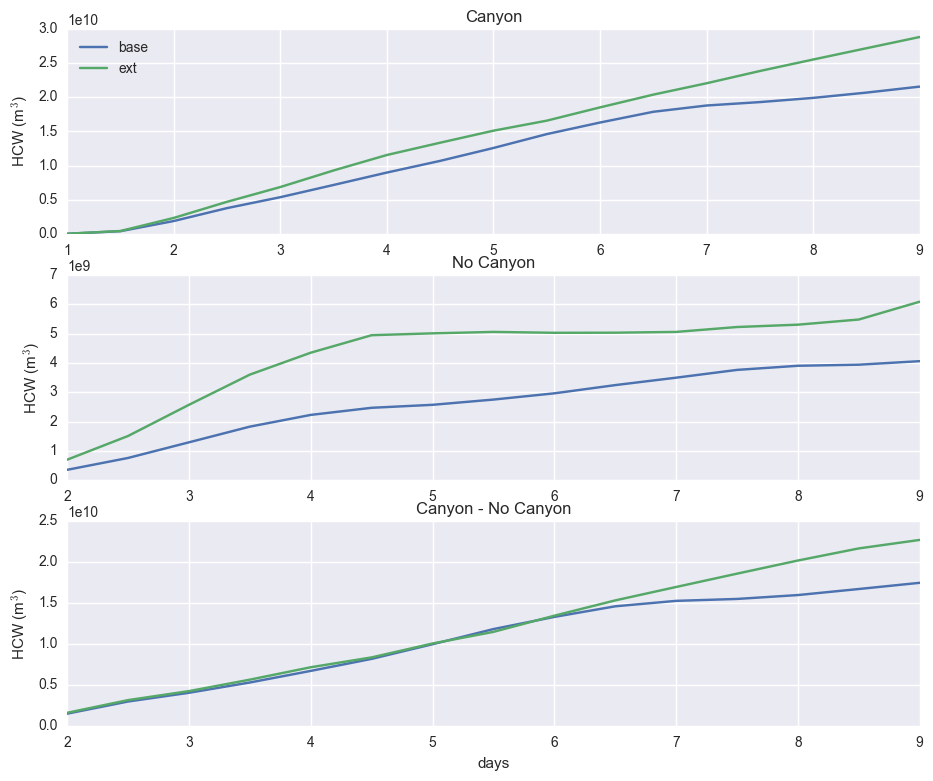

In [34]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(11,9))

ax1.plot(np.arange(19)/2, HCW_Can,label='base')
ax1.plot(np.arange(19)/2, HCW_CanExt,label='ext')
ax1.set_title('Canyon')

ax2.plot(np.arange(19)/2, HCW_NoC)
ax2.plot(np.arange(19)/2, HCW_NoCExt)
ax2.set_title('No Canyon')

ax3.plot(np.arange(19)/2, HCW_Can-HCW_NoC)
ax3.plot(np.arange(19)/2, HCW_CanExt-HCW_NoCExt)
ax3.set_title('Canyon - No Canyon')

ax3.set_xlabel('days')
ax1.set_ylabel('HCW (m$^3$)')
ax2.set_ylabel('HCW (m$^3$)')
ax3.set_ylabel('HCW (m$^3$)')

ax1.legend(loc=0)

There is not much difference between both methods for the canyon case, but the no canyon case is very different, why? Where does the discrepancy come from? Let's look at some alongshore and cross-shore integrated sections. I'm not overcounting water, if anything I'm setting a lower bound for water upwelled nto shelf because you need a lot of water to change the concentration of a cell to be larger than Cs...

### HCW Alongshore 

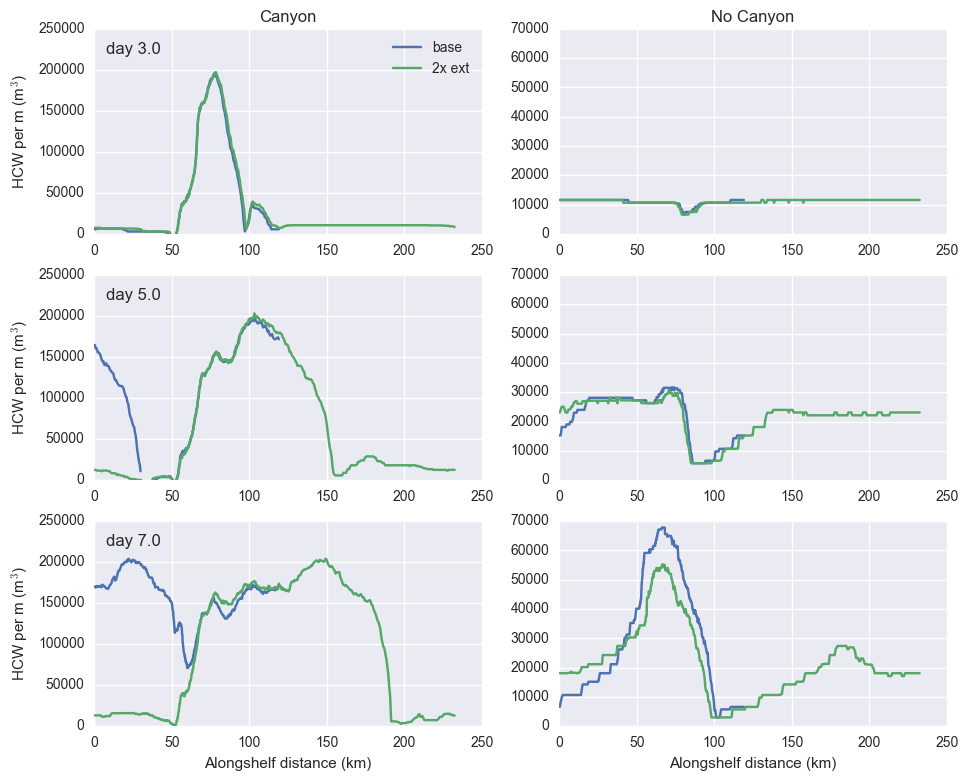

In [52]:
fig,ax = plt.subplots(3,2,figsize=(11,9))

ax[0,0].set_title('Canyon')
ax[0,1].set_title('No Canyon')

ii = 0    
for tt in [6,10,14]:
    
    ax[ii,0].plot(xc[0,:-1]/1000, HCW_Can_along[tt,:]/dxg[0,:-1],label='base')
    ax[ii,0].plot(xc_ext[0,:-1]/1000, HCW_Can_alongExt[tt,:]/dxg_ext[0,:-1],label='2x ext')
    
    ax[ii,0].set_ylabel('HCW per m (m$^3$)')
    ax[ii,0].set_ylim(0,250000)
    ax[ii,0].text(0.1, 0.9,'day %1.1f' %(tt/2), ha='center', va='center', transform=ax[ii,0].transAxes)
    ax[ii,1].plot(xc[0,:-1]/1000, HCW_NoC_along[tt,:]/dxg[0,:-1],label='base')
    ax[ii,1].plot(xc_ext[0,:-1]/1000, HCW_NoC_alongExt[tt,:]/dxg_ext[0,:-1],label='2X')
    
    ax[ii,1].set_ylim(0,70000)

    ii = ii + 1

ax[2,0].set_xlabel('Alongshelf distance (km)')
ax[2,1].set_xlabel('Alongshelf distance (km)')

ax[0,0].legend(loc=0)

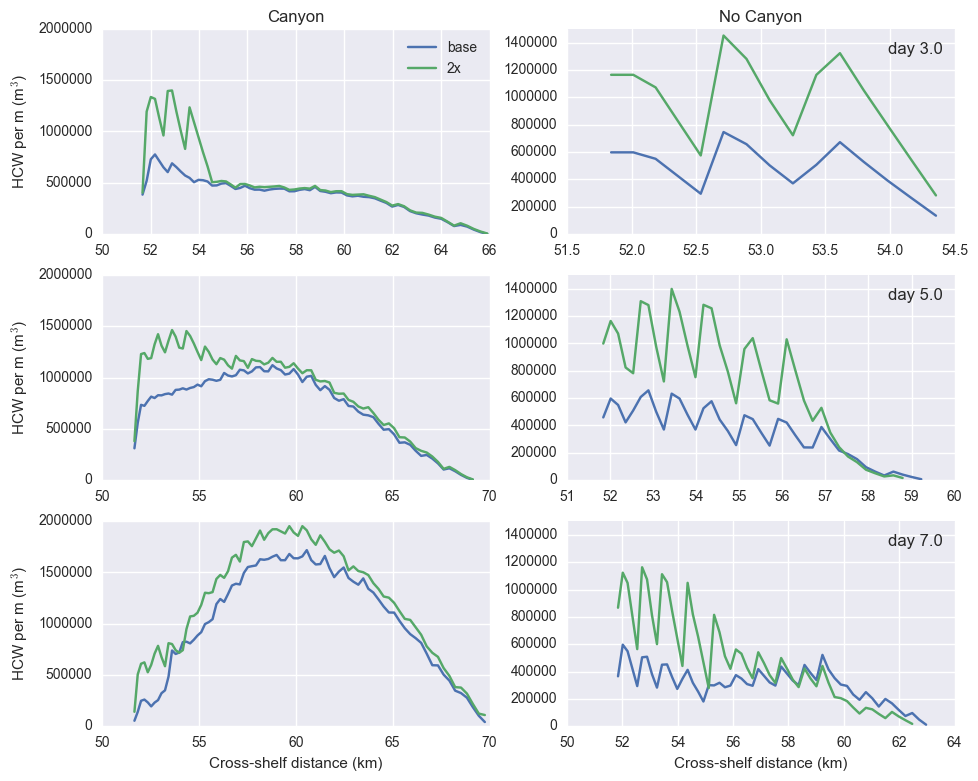

In [57]:
fig,ax = plt.subplots(3,2,figsize=(11,9))

ax[0,0].set_title('Canyon')
ax[0,1].set_title('No Canyon')

ii = 0    
for tt in [6,10,14]:
    
    ax[ii,0].plot(yc[227:,0]/1000, HCW_Can_across[tt,:]/dyg[227:,0],label='base')
    ax[ii,0].plot(yc[227:,0]/1000, HCW_Can_acrossExt[tt,:]/dyg[227:,0],label='2x')
   
    ax[ii,0].set_ylabel('HCW per m (m$^3$)')
    ax[ii,0].set_ylim(0,2000000)
    ax[ii,1].text(0.9, 0.9,'day %1.1f' %(tt/2), ha='center', va='center', transform=ax[ii,1].transAxes)
    ax[ii,1].plot(yc[227:,0]/1000, HCW_NoC_across[tt,:]/dyg[227:,0],label='base')
    ax[ii,1].plot(yc[227:,0]/1000, HCW_NoC_acrossExt[tt,:]/dyg[227:,0],label='2x')
    ax[ii,1].set_ylim(0,1500000)

    ii = ii + 1

ax[2,0].set_xlabel('Cross-shelf distance (km)')
ax[2,1].set_xlabel('Cross-shelf distance (km)')

ax[0,0].legend(loc=0)

### Cross-shelf sections for no-canyon case

In [19]:

filename1=('/data/kramosmu/results/TracerExperiments/CNTDIFF/run78/ptracersGlob.nc')
Tr2 = rout.getField(filename1,'Tr2') 
maskExp = mtt.maskExpand(MaskCNoC,Tr2)
Tr2_step_mask = np.ma.array(Tr2,mask=maskExp)   
    
filename2=('/data/kramosmu/results/TracerExperiments/CNTDIFF/run42/ptracersGlob.nc' )
Tr2 = rout.getField(filename2,'Tr2') 
Tr2_lin_mask = np.ma.array(Tr2,mask=maskExp)   


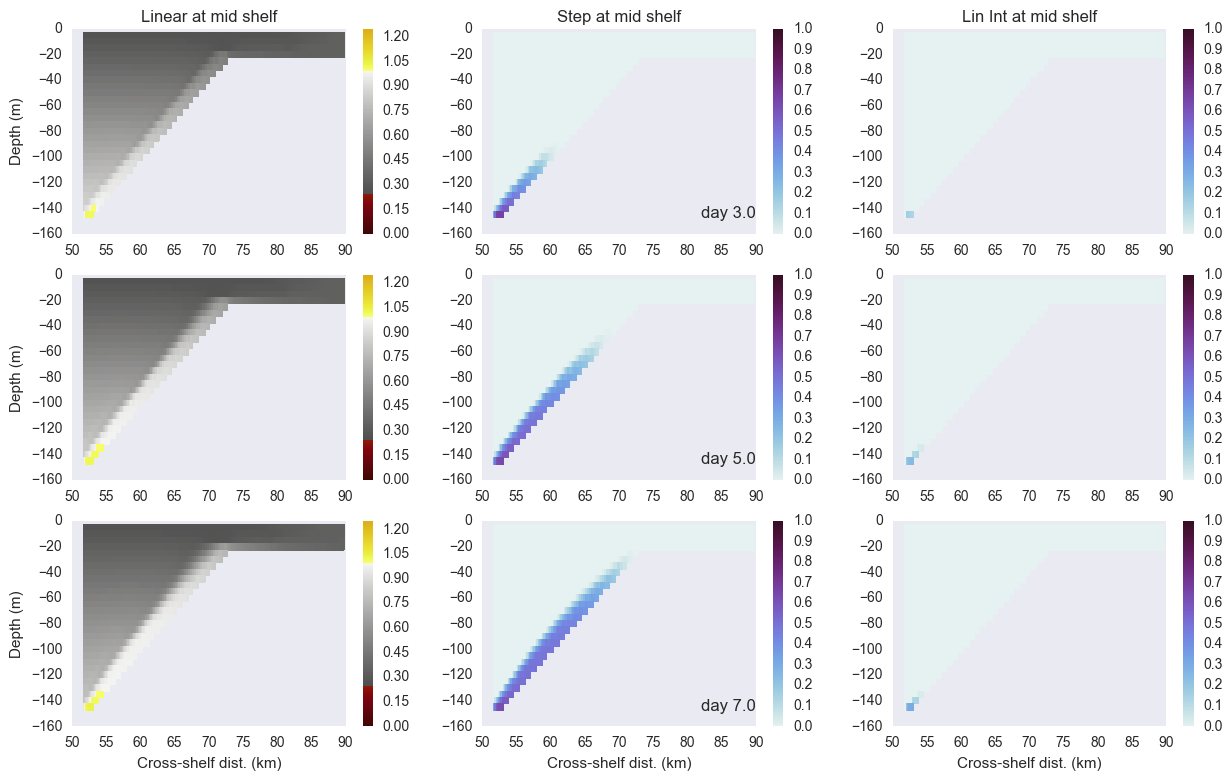

In [19]:
fig,ax = plt.subplots(3,3,figsize=(15,9))

ax[0,0].set_title('Linear at mid shelf')
ax[0,1].set_title('Step at mid shelf')
ax[0,2].set_title('Lin Int at mid shelf')

ii = 0    
for tt in [6,10,14]:
    
    pcol1 = ax[ii,0].pcolor(yc[227:,0]/1000,z[:30], Tr2_lin_mask[tt,:30,227:,180]/Tr2_lin_mask[0,30,100,200],
                    vmin=0,vmax=1.25, cmap=cmo.cm.oxy)
    plt.colorbar(pcol1,ax=ax[ii,0])
    ax[ii,0].set_ylabel('Depth (m)')
    pcol2 = ax[ii,1].pcolor(yc[227:,0]/1000,z[:30], Tr2_step_mask[tt,:30,227:,180]/Tr2_step_mask[0,30,100,200],
                    vmin=0,vmax=1,cmap=cmo.cm.dense)
    plt.colorbar(pcol2,ax=ax[ii,1])
    pcol3 = ax[ii,2].pcolor(yc[227:,0]/1000,z[:30], 
                            (Tr2_lin_mask[tt,:30,227:,180]-Tr2_lin_mask[0,30,50,180]),
                             vmin=0,vmax=1,cmap=cmo.cm.dense)
    plt.colorbar(pcol3,ax=ax[ii,2])
    ax[ii,2].text(0.9, 0.1,'day %1.1f' %(tt/2), ha='center', va='center', transform=ax[ii,1].transAxes)
    
    ii = ii + 1

ax[ii-1,0].set_xlabel('Cross-shelf dist. (km)')
ax[ii-1,1].set_xlabel('Cross-shelf dist. (km)')
ax[ii-1,2].set_xlabel('Cross-shelf dist. (km)')
    


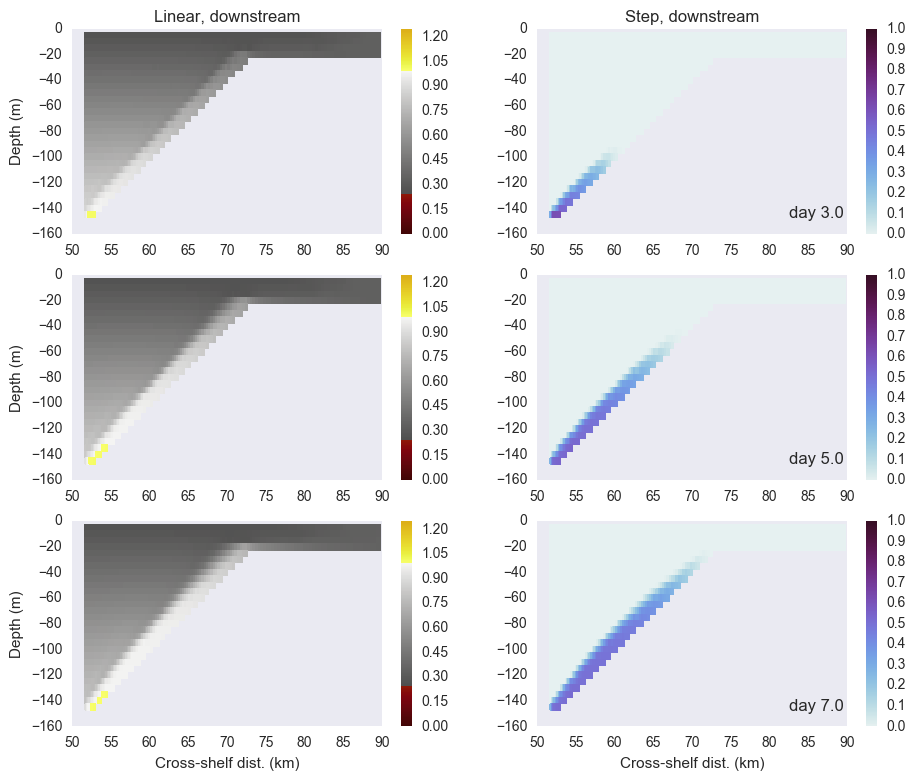

In [20]:
fig,ax = plt.subplots(3,2,figsize=(11,9))

ax[0,0].set_title('Linear, downstream')
ax[0,1].set_title('Step, downstream')

ii = 0    
for tt in [6,10,14]:
    
    pcol1 = ax[ii,0].pcolor(yc[227:,0]/1000,z[:30], Tr2_lin_mask[tt,:30,227:,240]/Tr2_lin_mask[0,30,100,200],
                    vmin=0,vmax=1.25, cmap=cmo.cm.oxy)
    plt.colorbar(pcol1,ax=ax[ii,0])
    ax[ii,0].set_ylabel('Depth (m)')
    pcol2 = ax[ii,1].pcolor(yc[227:,0]/1000,z[:30], Tr2_step_mask[tt,:30,227:,240]/Tr2_step_mask[0,30,100,200],
                    vmin=0,vmax=1,cmap=cmo.cm.dense)
    plt.colorbar(pcol2,ax=ax[ii,1])
    ax[ii,1].text(0.9, 0.1,'day %1.1f' %(tt/2), ha='center', va='center', transform=ax[ii,1].transAxes)

    ii = ii + 1

ax[ii-1,0].set_xlabel('Cross-shelf dist. (km)')
ax[ii-1,1].set_xlabel('Cross-shelf dist. (km)')
    

So, the step method is finding more cells with c>0 than the linear tracer cells with c>cs...

The colormap for the linear tracer (normalized by $C_s$) has been chosen so that cells with $C>1$ (which means $C>C_s$) are painted in yellow. The colormap for the step tracer was also normalized by $C_s$ so that the darker the color the closer the concentration to $C_s$.

### Cross-shelf sections canyon case

In [21]:
maskExp_can = mtt.maskExpand(MaskC,Tr2)

filename1=('/data/kramosmu/results/TracerExperiments/CNTDIFF/run77/ptracersGlob.nc')
Tr2 = rout.getField(filename1,'Tr2') 
Tr2_step_mask_can = np.ma.array(Tr2,mask=maskExp_can)   
    
filename2=('/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc' )
Tr2 = rout.getField(filename2,'Tr2') 
Tr2_lin_mask_can = np.ma.array(Tr2,mask=maskExp_can)   


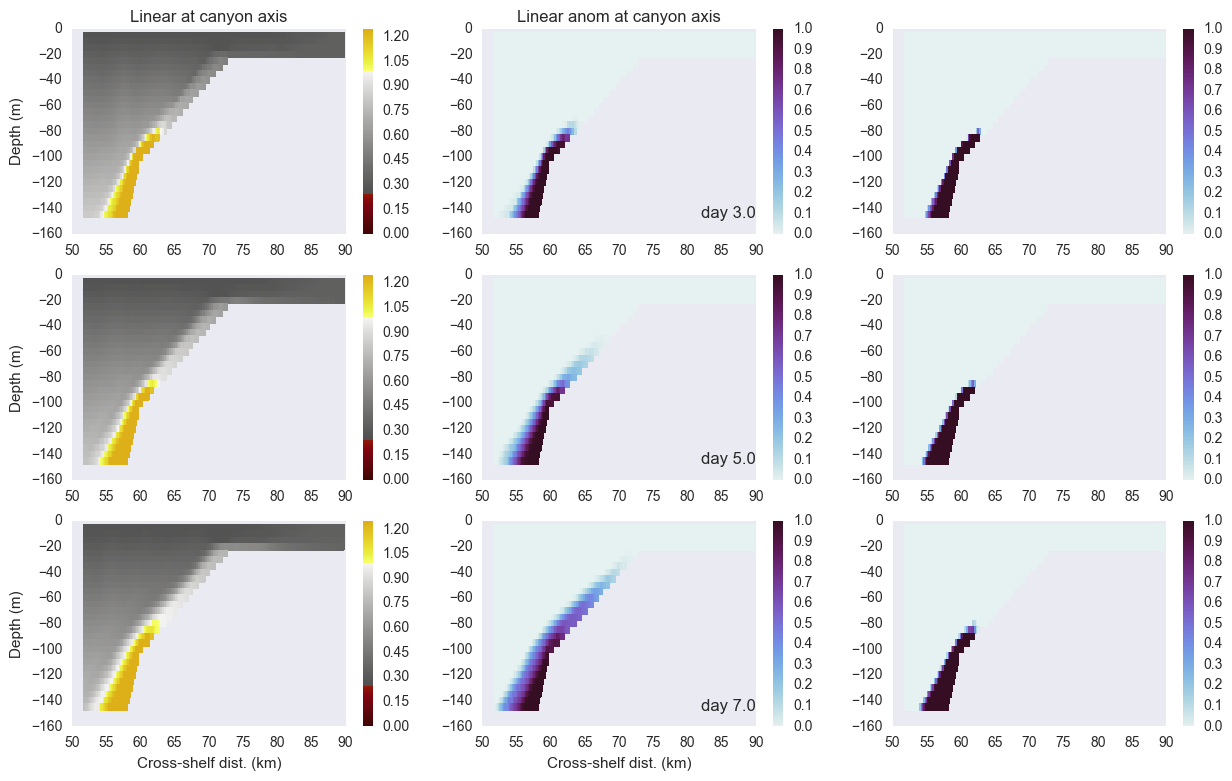

In [22]:
fig,ax = plt.subplots(3,3,figsize=(15,9))

ax[0,0].set_title('Linear at canyon axis')
ax[0,1].set_title('Step at canyon axis')
ax[0,1].set_title('Linear anom at canyon axis')

ii = 0    
for tt in [6,10,14]:
    
    pcol1 = ax[ii,0].pcolor(yc[227:,0]/1000,z[:30], Tr2_lin_mask_can[tt,:30,227:,180]/Tr2_lin_mask_can[0,30,100,200],
                    vmin=0,vmax=1.25, cmap=cmo.cm.oxy)
    plt.colorbar(pcol1,ax=ax[ii,0])
    ax[ii,0].set_ylabel('Depth (m)')
    
    pcol2 = ax[ii,1].pcolor(yc[227:,0]/1000,z[:30], Tr2_step_mask_can[tt,:30,227:,180]/Tr2_step_mask_can[0,30,100,200],
                    vmin=0,vmax=1,cmap=cmo.cm.dense)
    plt.colorbar(pcol2,ax=ax[ii,1])
    pcol3 = ax[ii,2].pcolor(yc[227:,0]/1000,z[:30], 
                            (Tr2_lin_mask_can[tt,:30,227:,180]-Tr2_lin_mask_can[0,30,50,180]),
                            vmin=0,vmax=1,cmap=cmo.cm.dense)
    plt.colorbar(pcol3,ax=ax[ii,2])
    ax[ii,1].text(0.9, 0.1,'day %1.1f' %(tt/2), ha='center', va='center', transform=ax[ii,1].transAxes)

    ii = ii + 1

ax[ii-1,0].set_xlabel('Cross-shelf dist. (km)')
ax[ii-1,1].set_xlabel('Cross-shelf dist. (km)')


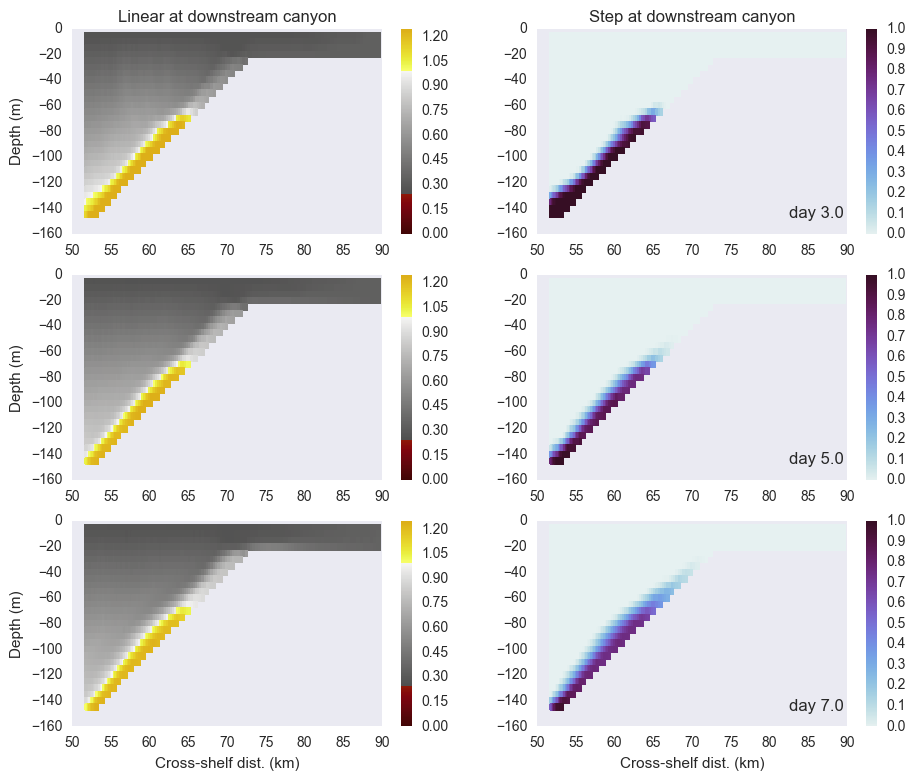

In [19]:
fig,ax = plt.subplots(3,2,figsize=(11,9))

ax[0,0].set_title('Linear at downstream canyon')
ax[0,1].set_title('Step at downstream canyon')

ii = 0    
for tt in [6,10,14]:
    
    pcol1 = ax[ii,0].pcolor(yc[227:,0]/1000,z[:30], Tr2_lin_mask_can[tt,:30,227:,240]/Tr2_lin_mask_can[0,30,100,200],
                    vmin=0,vmax=1.25, cmap=cmo.cm.oxy)
    plt.colorbar(pcol1,ax=ax[ii,0])
    ax[ii,0].set_ylabel('Depth (m)')
    
    pcol2 = ax[ii,1].pcolor(yc[227:,0]/1000,z[:30], Tr2_step_mask_can[tt,:30,227:,240]/Tr2_step_mask_can[0,30,100,200],
                    vmin=0,vmax=1,cmap=cmo.cm.dense)
    plt.colorbar(pcol2,ax=ax[ii,1])
    ax[ii,1].text(0.9, 0.1,'day %1.1f' %(tt/2), ha='center', va='center', transform=ax[ii,1].transAxes)

    ii = ii + 1

ax[ii-1,0].set_xlabel('Cross-shelf dist. (km)')
ax[ii-1,1].set_xlabel('Cross-shelf dist. (km)')

### Tracer inventory on shelf

In [20]:
# CANYON
filename=('/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc')
Tr1 = rout.getField(filename,'Tr1') 
TrInv = calc_TrInvent(Tr1, MaskCNoC, rA, hFacCNoC, drF[:],nzlim=29, 
                      yin=227, xin=0, xfin=359, 
                      zfin=29, xi=180, yi=50)

# NO-CANYON
filename=('/data/kramosmu/results/TracerExperiments/CNTDIFF/run42/ptracersGlob.nc')
Tr1 = rout.getField(filename,'Tr1') 
TrInv_NoC = calc_TrInvent(Tr1, MaskCNoC, rA, hFacCNoC, drF[:],nzlim=29, 
                          yin=227, xin=0, xfin=359, 
                          zfin=29, xi=180, yi=50)


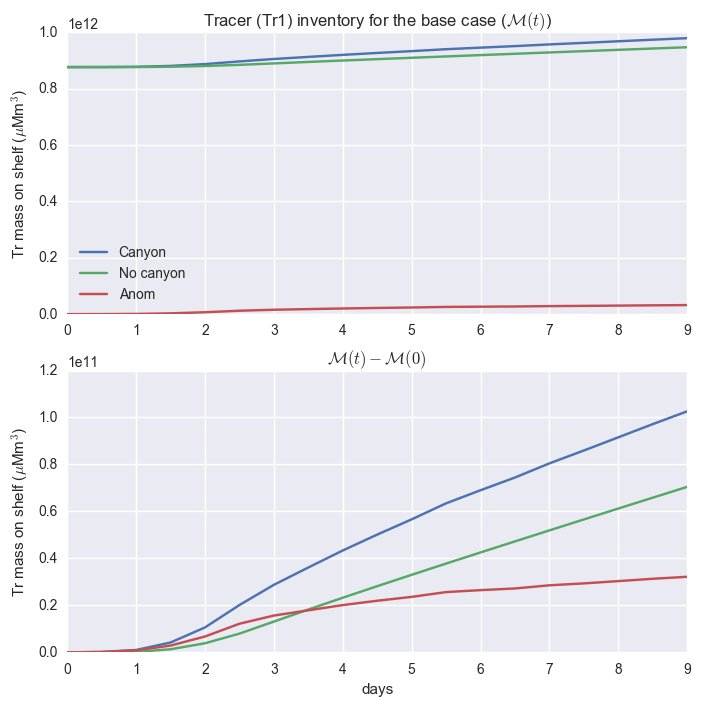

In [29]:
fig,(ax1,ax2) = plt.subplots(2,1, figsize=(8,8))

ax1.plot(np.arange(19)/2, TrInv,label='Canyon')
ax1.plot(np.arange(19)/2, TrInv_NoC,label='No canyon')
ax1.plot(np.arange(19)/2, TrInv-TrInv_NoC,label='Anom')
ax1.set_title('Tracer (Tr1) inventory for the base case ($\mathcal{M}(t)$)')

ax1.set_ylabel('Tr mass on shelf ($\mu$Mm$^3$)')

ax2.plot(np.arange(19)/2, TrInv-TrInv[0],label='Canyon')
ax2.plot(np.arange(19)/2, TrInv_NoC-TrInv_NoC[0],label='No canyon')
ax2.plot(np.arange(19)/2, TrInv-TrInv_NoC,label='Anom')
ax2.set_title('$\mathcal{M}(t)-\mathcal{M}(0)$')

ax2.set_xlabel('days')
ax2.set_ylabel('Tr mass on shelf ($\mu$Mm$^3$)')

ax1.legend(loc=0)

Sure, the change in the overall tracer inventory is small (from canyon to no-canyon cases) but the comparison is a bit unfair given that the shelf volume is huge compared to the canyon. When we look at the increase of tracer mass on shelf (taking away the initial mass on shelf), the canyon increases the tracer mass increase by about 30% compared to the no canyon case. (What I mean is that it was already a small increase without the canyon.)

In [30]:
# CANYON
filename=('/data/kramosmu/results/TracerExperiments/CNTDIFF/run77/ptracersGlob.nc')
Tr2 = rout.getField(filename,'Tr2') 
TrInv_step = calc_TrInvent(Tr2, MaskCNoC, rA, hFacCNoC, drF[:],nzlim=29, 
                      yin=227, xin=0, xfin=359, 
                      zfin=29, xi=180, yi=50)

# NO-CANYON
filename=('/data/kramosmu/results/TracerExperiments/CNTDIFF/run78/ptracersGlob.nc')
Tr2 = rout.getField(filename,'Tr2') 
TrInv_step_NoC = calc_TrInvent(Tr2, MaskCNoC, rA, hFacCNoC, drF[:],nzlim=29, 
                          yin=227, xin=0, xfin=359, 
                          zfin=29, xi=180, yi=50)


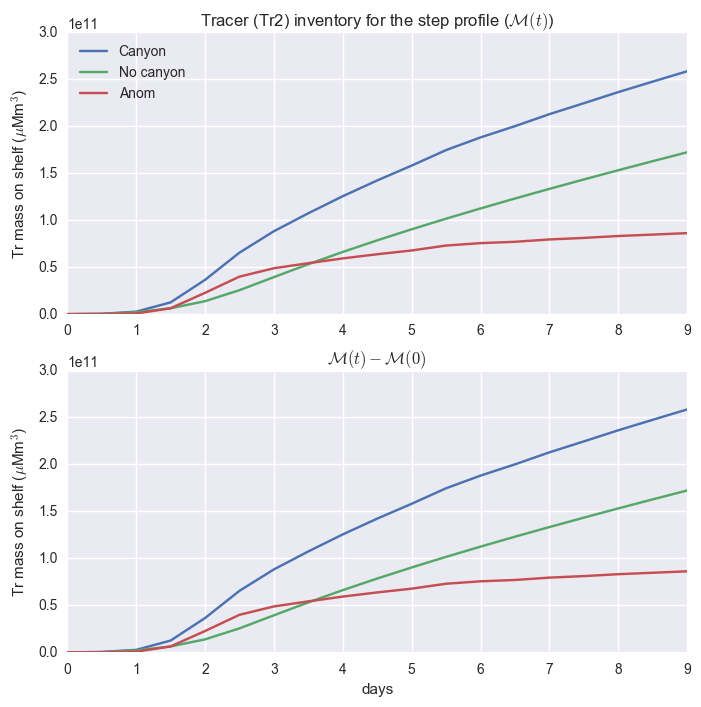

In [31]:
fig,(ax1,ax2) = plt.subplots(2,1, figsize=(8,8))

ax1.plot(np.arange(19)/2, TrInv_step,label='Canyon')
ax1.plot(np.arange(19)/2, TrInv_step_NoC,label='No canyon')
ax1.plot(np.arange(19)/2, TrInv_step-TrInv_step_NoC,label='Anom')
ax1.set_title('Tracer (Tr2) inventory for the step profile ($\mathcal{M}(t)$)')

ax1.set_ylabel('Tr mass on shelf ($\mu$Mm$^3$)')

ax2.plot(np.arange(19)/2, TrInv_step-TrInv_step[0],label='Canyon')
ax2.plot(np.arange(19)/2, TrInv_step_NoC-TrInv_step_NoC[0],label='No canyon')
ax2.plot(np.arange(19)/2, TrInv_step-TrInv_step_NoC,label='Anom')
ax2.set_title('$\mathcal{M}(t)-\mathcal{M}(0)$')

ax2.set_xlabel('days')
ax2.set_ylabel('Tr mass on shelf ($\mu$Mm$^3$)')

ax1.legend(loc=0)

The inventory for the step tracer (no tracer on shelf initially) behaves the same...